<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

In [13]:
MAX_VOCAB_SIZE = 8000
MAX_LENGTH = 20
N_UNITS = 128
EPOCHS = 45
LSTM_DROPOUT = 0.2

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [14]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [15]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.utils import plot_model
from keras.utils import to_categorical

In [16]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [17]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [18]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [19]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = MAX_LENGTH

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 1903


In [20]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [21]:
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Total tokens in input vocab:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Longest input sentence:", max_input_len)

Total tokens in input vocab: 752
Longest input sentence: 7


In [22]:
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Total tokens in output vocab:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)
print("Total tokens in output:", num_words_output)

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Longest output sentence:", max_out_len)

Total tokens in output vocab: 714
Total tokens in output: 715
Longest output sentence: 7


In [23]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences shape:", decoder_output_sequences.shape)

decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
print("decoder_targets shape:", decoder_targets.shape)

encoder_input_sequences shape: (1903, 7)
decoder_input_sequences shape: (1903, 7)
decoder_output_sequences shape: (1903, 7)
decoder_targets shape: (1903, 7, 715)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [24]:
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Dataset already downloaded")


Dataset already downloaded


In [25]:
import logging
from pathlib import Path
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2 ** 28 - 1
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        max_bytes = 2 ** 28 - 1
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx + max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [26]:
model_embeddings = FasttextEmbeddings()

In [27]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix ** 2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [28]:
embedding_matrix.shape

(753, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [29]:
# define training encoder
encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
    input_dim=nb_words,
    output_dim=embed_dim,
    input_length=max_input_len,
    weights=[embedding_matrix],
    trainable=False)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(N_UNITS,
               return_state=True,
               dropout=LSTM_DROPOUT,
               )

encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output,
    output_dim=N_UNITS,
    input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(N_UNITS,
                    return_sequences=True,
                    return_state=True,
                    dropout=LSTM_DROPOUT,
                    )
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 7)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 7, 300)               225900    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 7, 128)               91520     ['input_2[0][0]']             
                                                                                              

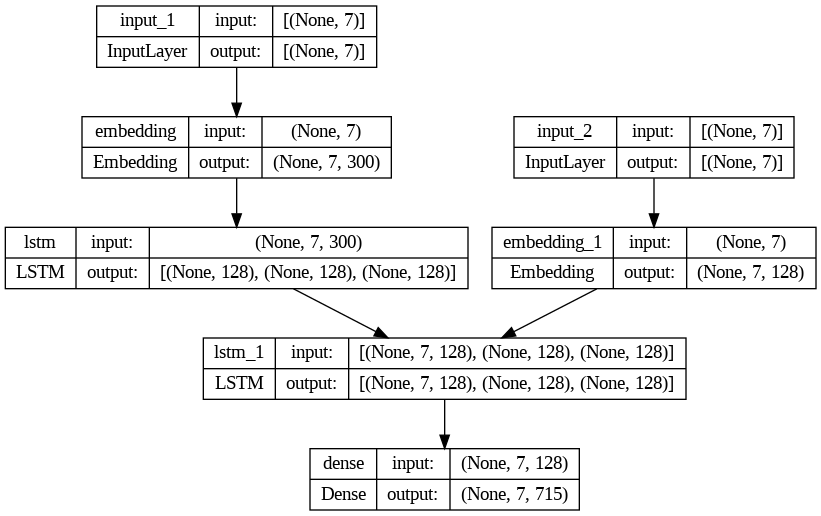

In [30]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

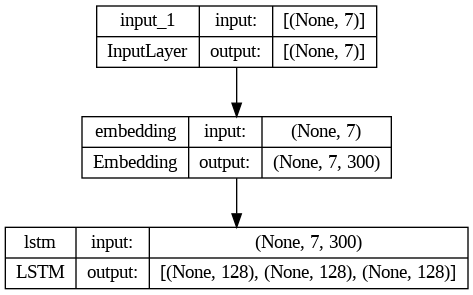

In [31]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

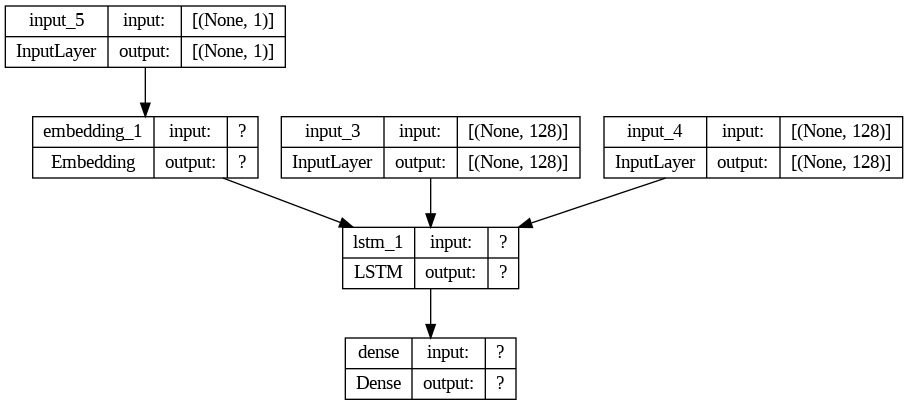

In [32]:
decoder_state_input_h = Input(shape=(N_UNITS,))
decoder_state_input_c = Input(shape=(N_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=EPOCHS,
    validation_split=0.2,
    )

Epoch 1/45
48/48 [==============================] - 24s 133ms/step - loss: 3.8805 - accuracy: 0.4579 - val_loss: 2.8547 - val_accuracy: 0.4691
Epoch 2/45
48/48 [==============================] - 1s 28ms/step - loss: 2.4231 - accuracy: 0.5097 - val_loss: 2.5063 - val_accuracy: 0.5486
Epoch 3/45
48/48 [==============================] - 1s 18ms/step - loss: 2.1437 - accuracy: 0.6039 - val_loss: 2.3489 - val_accuracy: 0.6288
Epoch 4/45
48/48 [==============================] - 1s 16ms/step - loss: 1.9999 - accuracy: 0.6388 - val_loss: 2.2995 - val_accuracy: 0.6307
Epoch 5/45
48/48 [==============================] - 1s 22ms/step - loss: 1.8929 - accuracy: 0.6488 - val_loss: 2.2383 - val_accuracy: 0.6430
Epoch 6/45
48/48 [==============================] - 1s 14ms/step - loss: 1.7765 - accuracy: 0.6735 - val_loss: 2.1787 - val_accuracy: 0.6554
Epoch 7/45
48/48 [==============================] - 1s 12ms/step - loss: 1.6614 - accuracy: 0.7092 - val_loss: 2.1177 - val_accuracy: 0.6644
Epoch 8/45


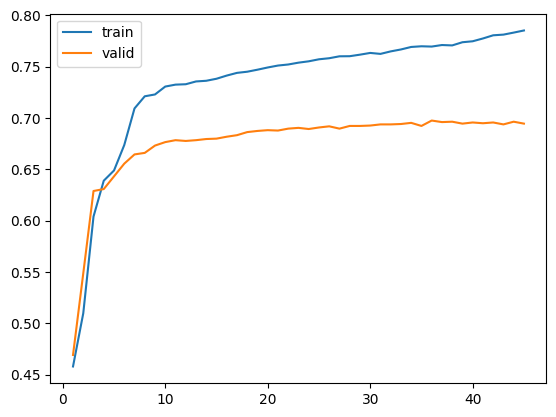

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [35]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [36]:
def answer_prompt(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    eos = word2idx_outputs['<eos>']

    output_sentence = []
    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        states_value = [h, c]
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [37]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = answer_prompt(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', translation)

1/1 [==============================] - 0s 19ms/step
-
Input: okay
Response: i love to read


In [38]:
input_test = "Do you read?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Do you read?
Representacion en vector de tokens de ids [9, 2, 12]
Padding del vector: [[ 0  0  0  0  9  2 12]]
Input: Do you read?
1/1 [==============================] - 0s 21ms/step
Response: yes


In [39]:
input_test = 'Do you have any pet?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Do you have any pet?
Representacion en vector de tokens de ids [9, 2, 24, 107, 347]
Padding del vector: [[  0   0   9   2  24 107 347]]
Input: Do you have any pet?
1/1 [==============================] - 0s 29ms/step
Response: i am a student


In [40]:
input_test = 'Where are you from?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Where are you from?
Representacion en vector de tokens de ids [29, 4, 2, 40]
Padding del vector: [[ 0  0  0 29  4  2 40]]
Input: Where are you from?
1/1 [==============================] - 0s 21ms/step
Response: i am a female


In [42]:
input_test = 'Who are you?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: Who are you?
Representacion en vector de tokens de ids [125, 4, 2]
Padding del vector: [[  0   0   0   0 125   4   2]]
Input: Who are you?
1/1 [==============================] - 0s 24ms/step
Response: i am a female


In [41]:
input_test = 'How are you?'
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
translation = answer_prompt(encoder_sequence_test)
print('Response:', translation)

Input: How are you?
Representacion en vector de tokens de ids [8, 4, 2]
Padding del vector: [[0 0 0 0 8 4 2]]
Input: How are you?
1/1 [==============================] - 0s 19ms/step
Response: i m fine


## Conclusion

Las preguntas que no estan asociadas a una persona como "do you read?" o "how are you?" obtienen buenos resultados, aunque realmente genericos.

Cuando la pregunta ya esta asociada con cuestiones propias de una persona, como "where are you from?", "do you have any pet?" o "who are you?" devuelve resultados que no serian propios de una conversacion normal.

Por lo observado, dataset parece ser demasiado simple y abstracto como para que pueda arrojar mejores resultados que los obtenido. El resultado es un chatbot bastante pobre.

